**Problem Setting and Approach**

Movielens, a plartform for non-commercial personalized movie recommendations has made available several movie datasets. Throughout this kernel, we will use the dataset provided by the dslabs package.
Before modelling, we will visually explore our data and clean it whenever possible.
Our prediction attempt will focus in matrix factoriazation.

**Model Basis**

We will approach the prediction of rating in the following manner:
* The mean rating of all movies is the easiest, yet justified, prediction we could give. By taking a look at the of ratings, it becomes obvious that the mean has the highest probability to happen. For example, we were asked to pick a rating for a movie we don't know from a user we also don't know, the safest guess would be the mean. But since we have features available, we will try to use them as follows.
* On top of the mean rating, we can add the mean of the specific movie we want to predict. For example, Lord of the Rings is widely considered a good movie. Its mean rating will be way higher than the overall mean (which is shaped by both renowned and not so-acclaimed movies). As a result, a good movie's average will raise our prediction, while a bad movie's will decrease respectively. A common word in statistics used to describe such effects is bias. Thus, we'll call it movie bias and calculate is as the difference between mean rating of all movies and the mean rating of the specific movie we want to predict a rating for. For example, if we suppose the mean rating of all movies is 3.5, but Lord of the Rings has a mean rating of 4.5, then the movie bias of Lord of the Rings is 1 ( = 4.5 - 3.5).
* Accordingly, the same happens with users. Some users are demanding and tend to rate lower than others. We also need to take this under consideration. Continuing the example above, a user with mean rating of 2 will get a -1.5 ( = 2 - 3.5) user bias effect in our prediction.

**Considering the number of ratings**

The fact that not all movies bear the same number of ratings creates a distortion. For movies (the same applies to users) with many ratings, it's safer for us to base our prediction on their calculated bias. But it becomes overt that movies with low ratings may lead us to assign biases they don't actually deserve. This discrepancy can be rectified by adjusting the way we compute each movie's average rating. Movie bias is calculated by computing the difference between each rating and the mean rating of all movies, summing up all these differences and diving by the number of movie ratings to make this measure average. In order to control for the number of ratings (that is, take into more consideration a movie's ratings if it has many ratings and vice versa), we will add a penalty term when dividing with the sum of all differences from the mean. This way, movies with many ratings will get almost no influenced at all by the penalty, while movies with few ratings might get their average bias halfed or more.

To make it more straightforward, we can consider a very popular movie with a sum of differences from all movies average at 2000, number of ratings of 2500 and a penalty term of 4. Before penalization, the popular movie would yield a movie bias of +0.8 (= 20,000/25,000). After penalization, it would return 0.799 (= 20,000 / 25,004), almost the same as before.
On the other hand, a not-so-popular movie with just two ratings and a sum of (two) differences at +3, would return, before penalization, a movie bias of +1.5 ( = 3 / 2) . After, penalization it would become significantly lower at .5 ( = 3 / 6 ).

Thus, it becomes obvious that penalization minimizes biases based on a few ratings, while it leaves almost untouched biases returned by a great number of ratings. A common term for this penalty is lamba ( the greek l, λ), and that's how we'll call it throughout this analysis.  Since lambda is a tuning parameter, we need to choose the best. We will cross-validate (ie try different values and compute their efficiency) to get an optimal penalty term for both the movie and the user biases.

**Factorizing the residuals**

So far, the formula of our prediction is formed as follows:

prediction = mean_rating_of_all_movies + movie_bias + user_bias

or

$ \hat{y} = \mu + b_i + b_u $

The difference between prediction and reality is the sum of residuals (notated with the greek epsilon $ε$)  

Although this naive model is a good basis, it is not enough. We need to analyze its residuals and take more out of it. Inside the ratings matrix, exist many groups of users and movies somehow corellated. Some users like thriller and tend to rate them higher, others like Leonardo di Caprio, others dispise romance movies, etc. These trends are usually called latent factors or concepts and are almost infinite.  

In order to detect and take into consideration the most important of them, we will employ a technique called matrix factorization. 

The first step to factorize the residuals is to spread them in a sparse matrix. That means we convert each user into a row, each movie into a column and the values of this matrix are the corresponding ratings. Its dimensions are number of users x number of movies . Since users haven't rated all movies, this matrix will be very sparse, containing NAs wherever  a user has not rated a particular movie.

Our goal is to decompose this sparse matrix of residuals into 3 dense matrices, which, multiplied with each other, return a dense matrix very close to our initial sparse. In order to achieve it we will employ singular value decomposition (SVD for short). If we name our initial matrix of (m x n) dimensions A and the number of underlying concepts is k, we can represent Α as the multiplication of a (m x k) matrix (commonly notated as U) with a (k x k) nonnegative diagonal matrix (notated as Σ) and a (k x n) matrix (notated as V):

$A = UΣV^T$

This fairly computationally expensive process will be realized with the help of the funkSVD function from the recommenderlab package. After this transformation is achieved, we have managed to decompose our residuals $ε$. Each user-movie instance of residuals can be represented by a sum of multiplied values from the U, Σ, and T matrices. The residual of movie i and user j is rewritten as:

$ε_{i,j} = \sum p_{i,1} q_{1,j} + p_{i,2} q_{2,j} + ... + p_{i,k} q_{k,j}  $

Where $p$ and $q$ represent values from the matrices U and Q obtained by the SVD. k is the number of concepts with the variability of each term $p_{i,k} q_{k,j}$ decreasing (thus, concept 1 has more predictive power that concept 2 etc.)

This decomposition can be embedded in our model:

$ \hat{y} = \mu + b_i + b_u + p_{i,1} q_{1,j} + p_{i,2} q_{2,j}+ ... + p_{i,k} q_{k,j}$


**Libraries and Data**

Let's start our journey of exploring by importing libraries and data and taking a look at its structure.

In [1]:
#Importing necessary libraries
suppressPackageStartupMessages(require(tidyverse)) 
suppressPackageStartupMessages(require(recommenderlab)) #for the SVD decomposition
require(dslabs)
suppressPackageStartupMessages(require(gridExtra))
suppressPackageStartupMessages(require(splitstackshape))
suppressPackageStartupMessages(require(reshape2))

#Data import
data('movielens')

movielens <- movielens

#A look at our features
movielens %>% str()

Loading required package: dslabs


'data.frame':	100004 obs. of  7 variables:
 $ movieId  : int  31 1029 1061 1129 1172 1263 1287 1293 1339 1343 ...
 $ title    : chr  "Dangerous Minds" "Dumbo" "Sleepers" "Escape from New York" ...
 $ year     : int  1995 1941 1996 1981 1989 1978 1959 1982 1992 1991 ...
 $ genres   : Factor w/ 901 levels "(no genres listed)",..: 762 510 899 120 762 836 81 762 844 899 ...
 $ userId   : int  1 1 1 1 1 1 1 1 1 1 ...
 $ rating   : num  2.5 3 3 2 4 2 2 2 3.5 2 ...
 $ timestamp: int  1260759144 1260759179 1260759182 1260759185 1260759205 1260759151 1260759187 1260759148 1260759125 1260759131 ...


In [2]:
print(paste("There are ", movielens$movieId %>% n_distinct() - movielens$title %>% n_distinct(), "movies with the same title as some other"  ))

[1] "There are  234 movies with the same title as some other"


Quick thoughts of this first glance:
* movieId and title contain almost the same information. At times, titles are repeated. Thus, we expect unique movieIds to be more than the unique titles. For our model, we will only keep movieId as a predictor.
* year can contain little to no predictive power. People who like space movies will rate highly "2001:A space odyssey" as well as "Interstellar". It stays fot the EDA but we probably won't need it in our prediction.
* genres, even though they are very hard to use them directly in a model, will be a good signal for the number of underlying concepts in our data.
* timestamp contains no information at all. The time a rating is done has nothing to do with a user's preferences or the quality of a film.

In [3]:
movielens <- movielens %>% 
    select(-timestamp) %>% #getting rid of timestamp 
    mutate_if(is.integer, as.factor) #integers to factors

In [4]:
movielens %>% str()

'data.frame':	100004 obs. of  6 variables:
 $ movieId: Factor w/ 9066 levels "1","2","3","4",..: 31 834 860 907 932 1018 1042 1048 1084 1088 ...
 $ title  : chr  "Dangerous Minds" "Dumbo" "Sleepers" "Escape from New York" ...
 $ year   : Factor w/ 103 levels "1902","1915",..: 82 28 83 68 76 65 46 69 79 78 ...
 $ genres : Factor w/ 901 levels "(no genres listed)",..: 762 510 899 120 762 836 81 762 844 899 ...
 $ userId : Factor w/ 671 levels "1","2","3","4",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ rating : num  2.5 3 3 2 4 2 2 2 3.5 2 ...


**Distribution of Ratings**

Throughout our analysis, the mean of ratings will play a significant role. It will be the base of our prediction. Let's take a look at the distribution that shapes it.

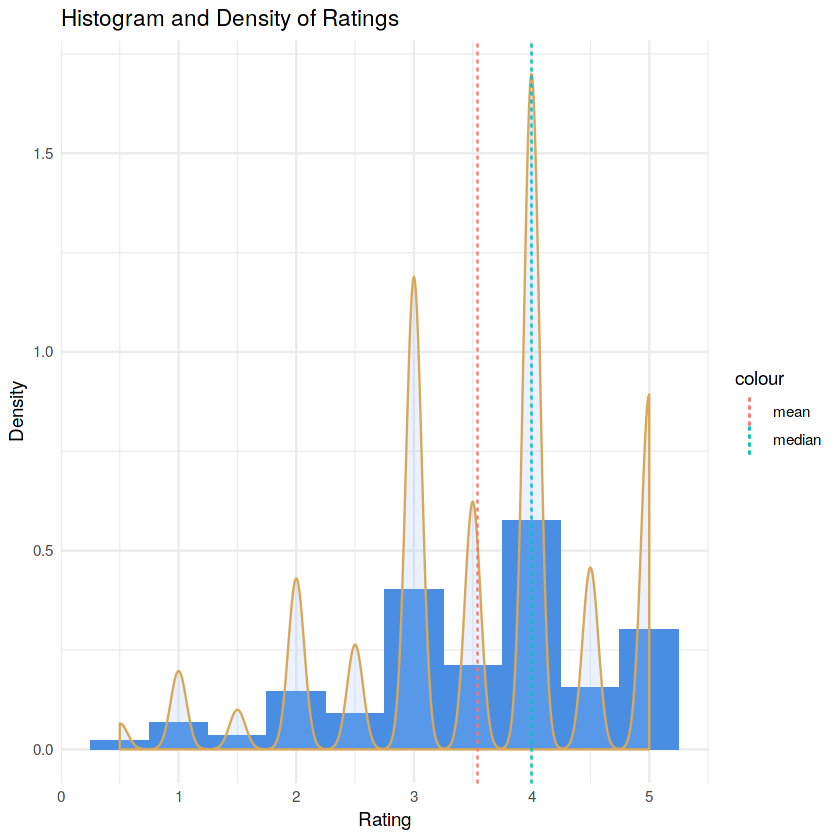

In [5]:
mu <- mean(movielens$rating)
med <- median(movielens$rating)


movielens %>% ggplot( aes(x=rating)) +   
   geom_histogram(aes(y=..density..),binwidth = .5,fill="#498ee3")+ 
   geom_density(aes(y=..density..), fill = "#99beff", col = '#d9a757', alpha = .2  )+ 
    geom_vline( aes( xintercept = mu, colour = "mean"), linetype ='dashed' ) + 
    geom_vline(aes( xintercept = med, colour = "median"), linetype ='dashed' )  +
    theme_minimal()+
    labs(title = "Histogram and Density of Ratings", x = "Rating", y = "Density")

Both the mean and the median are higher than half of the range (eg 2.5). That suggests a tendency towards high ratings. It looks like it is much more likely for someone to rate a movie she liked rather than one she didn't. Also, users are lenient with movies they don't like and seldom place ratings beneath 2.

**Count vs Mean Rating**

We want to check, both for users and movies, whether the number of ratings goes along with the mean rating. In other words, we seek to answer the question: "Do movies (users) with many ratings tend to have (give) high ratings and vice versa?"

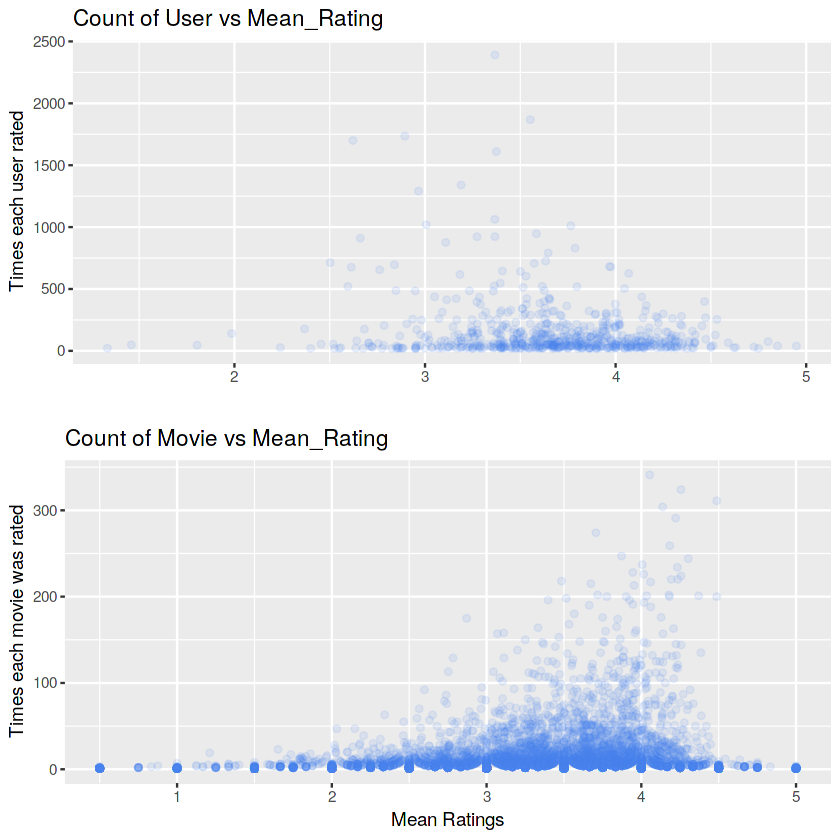

In [6]:
#Create a new dataframe containing the count of each user
cnt <- movielens %>% group_by(userId) %>% summarise( user_cnt = n() )

#average rating of each user
rat <- movielens %>% group_by(userId) %>% summarise( mean_rating = mean(rating) )

p1 <- cnt %>% left_join( rat, by = "userId" ) %>%
    ggplot( aes(y = user_cnt, x = mean_rating ) ) + 
    geom_point(show.legend = F, alpha = .1,col = "#4685f2") + 
    labs( title = "Count of User vs Mean_Rating", x = "", y = "Times each user rated" )

#count of each movie
cnt_mov<- movielens %>% group_by(movieId) %>% summarise( movie_cnt = n() )

#average rating of each movie
rat_mov <- movielens %>% group_by(movieId) %>% summarise( mean_rating = mean(rating) )

mov_df <- cnt_mov %>% left_join(rat_mov, by = "movieId" )

p2 <-  mov_df %>%
    ggplot( aes(y = movie_cnt, x = mean_rating ) ) + 
    geom_point(show.legend = F, alpha = .1,col = "#4685f2") + 
    labs( title = "Count of Movie vs Mean_Rating", x = "Mean Ratings", y = "Times each movie was rated" )

grid.arrange(p1,p2)

rm(cnt,rat,cnt_mov,rat_mov)

We notice a correlation for the movies. That could be a hint that popular movies tend to have high ratings. On the other hand, users don't show any strong tendency.

**Best and Worst Movies by Rating**

In [7]:
#Add the title from original dataset
mov_df$title <- movielens[match(mov_df$movieId, movielens$movieId),"title"]

In [8]:
#Best Movies without filtering the number of ratings
mov_df %>% arrange(desc(mean_rating)) %>% head()

movieId,movie_cnt,mean_rating,title
<fct>,<int>,<dbl>,<chr>
53,1,5,Lamerica
183,1,5,Mute Witness
301,1,5,Picture Bride (Bijo photo)
309,3,5,"Red Firecracker, Green Firecracker (Pao Da Shuang Deng)"
559,1,5,"Paris, France"
702,1,5,Faces


In [9]:
#Worst Movies without filtering the number of ratings
mov_df %>% arrange((mean_rating)) %>% head()

movieId,movie_cnt,mean_rating,title
<fct>,<int>,<dbl>,<chr>
1311,1,0.5,Santa with Muscles
2191,1,0.5,"Merry War, A"
2845,1,0.5,Whiteboyz
3883,1,0.5,Catfish in Black Bean Sauce
3933,1,0.5,"Killer Shrews, The"
4051,1,0.5,Horrors of Spider Island (Ein Toter Hing im Netz)


We notice here that neither the best nor the worst movies are widely known. On top of that, most of them shaped their mean by only one rating.
We will plot best and worst, but this time we will filter the number of ratings. As a lower limit we will get the first quantile of the number of ratings.

In [10]:
limit <- (mov_df$movie_cnt %>% summary())[5] #pick the 1rd quantile of the movie count as a low limit

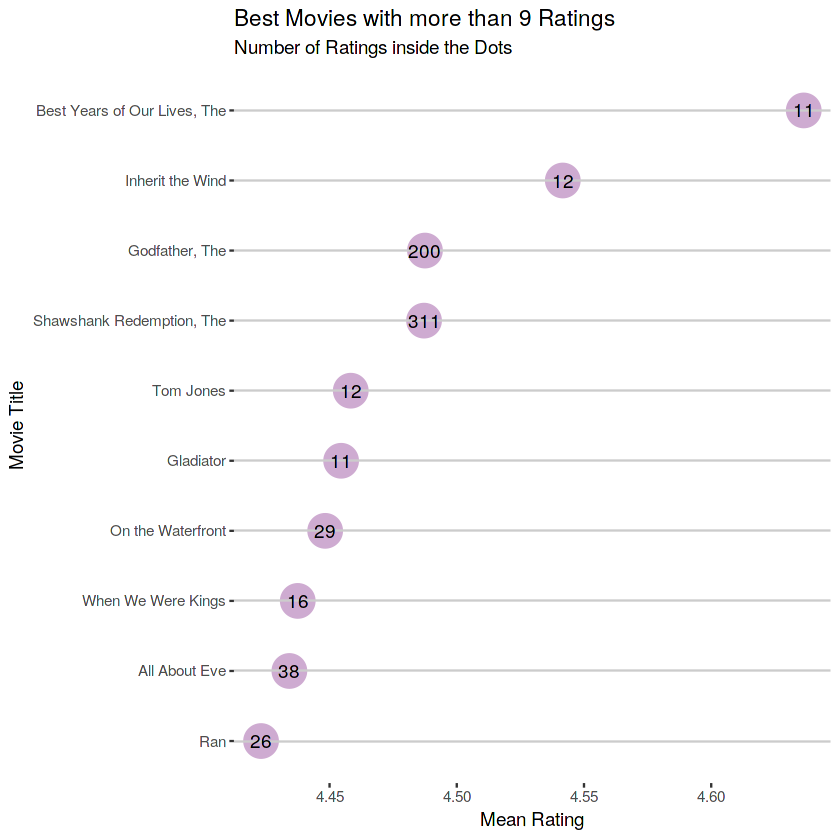

In [11]:
mov_df %>%
    filter(movie_cnt > limit) %>% #throw away movies with few ratings
    arrange(desc(mean_rating)) %>% #arrange from highest to lowest rating 
    slice(1:10) %>% #grab the first 10
    ggplot( aes(x = reorder(title,mean_rating), y = mean_rating) ) + 
    geom_point(size = 9, col = "#ceabd1") + coord_flip() +
    geom_vline(xintercept = 1:10, col = "grey80") + #lines on which our dots "walk"
    theme_classic()+ 
    theme(axis.line = element_blank()) +
    geom_text( aes(label = movie_cnt), col = "black" ) +
    labs(title = paste("Best Movies with more than",limit,"Ratings"), y = "Mean Rating", x = "Movie Title", subtitle = "Number of Ratings inside the Dots" )

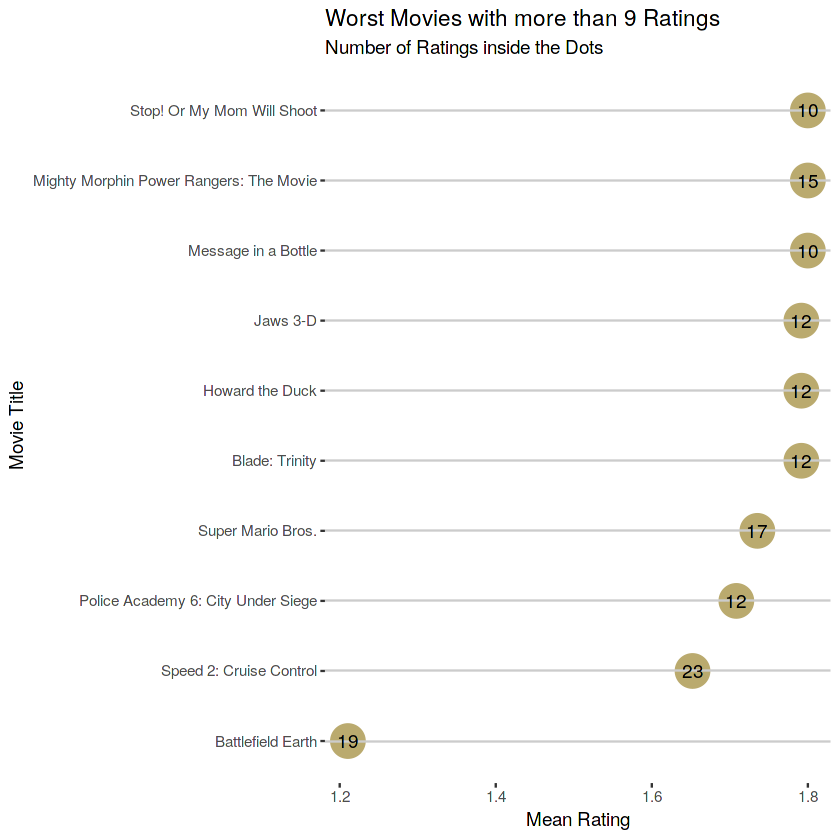

In [12]:
mov_df %>%
    filter(movie_cnt > limit) %>% #throw away movies with few ratings
    arrange((mean_rating)) %>% #arrange from highest to lowest rating 
    slice(1:10) %>% #grab the first 10
    ggplot( aes(x = reorder(title,mean_rating), y = mean_rating) ) + 
    geom_point(size = 9, col = "#baaa6e") + coord_flip() +
    geom_vline(xintercept = 1:10, col = "grey80") + #lines on which our dots "walk"
    theme_classic()+ 
    theme(axis.line = element_blank()) +
    geom_text( aes(label = movie_cnt), col = "black" ) +
    labs(title = paste("Worst Movies with more than",limit,"Ratings"), y = "Mean Rating", x = "Movie Title", subtitle = "Number of Ratings inside the Dots" )

Now we start to recognize the movies. Among the best are some all time classics, while among the worst are many commonly critised movies.

**Genres**

First, we will check out the distinct values of genres. Some genres are pretty similar (eg Horror and Thriller) and will get merged. After that, we will pick the most popular genres and the users with most ratings to explore each user's taste in movies.

At first, we will unnest the unique genres that exist in our column binded together.

In [13]:
#For every genre entry create a separate row containing only this entry
movielens_genres <- movielens %>%
        cSplit( "genres", sep="|", direction =  "long" ) #separate the genres column in a long direction 

Which genres are most frequent?

In [14]:
movielens_genres %>% group_by( genres ) %>% summarize( n = n() ) %>% arrange(n%>% desc()) %>% head()

genres,n
<fct>,<int>
Drama,44752
Comedy,38026
Action,27056
Thriller,25240
Adventure,22017
Romance,19336


In [15]:
movielens_genres %>% pull(genres) %>% unique()

[1] Drama              Animation          Children           Musical           
 [5] Thriller           Action             Adventure          Sci-Fi            
 [9] War                Fantasy            Horror             Romance           
[13] Comedy             Crime              Western            Mystery           
[17] IMAX               Documentary        Film-Noir          (no genres listed)
20 Levels: (no genres listed) Action Adventure Animation Children ... Western

We notice that some genres are pretty similar. We will merge some of them: 
* Horror to Thriller 
* Adventure to Action
* War to Action
* Sci-Fi to Fantasy

In [16]:
movielens_genres$genres <- plyr::revalue(movielens_genres$genres, c("Horror" = "Thriller", "Adventure" = "Action","War" = "Action" ,"Sci-Fi" = "Fantasy"))

#And the table of frequencies changes to:
movielens_genres %>% group_by( genres ) %>% summarize( n = n() ) %>% arrange(n%>% desc()) %>% head()

genres,n
<fct>,<int>
Action,54098
Drama,44752
Comedy,38026
Thriller,32030
Fantasy,26022
Romance,19336


Because genres are far too many to form informative plots we will keep the top 6 by number of ratings. The same applies to users.

In [17]:
#store top genres and users in variables for ease of filtering
top_genres <- movielens_genres %>% group_by( genres ) %>% summarize( n = n() ) %>% arrange(n%>% desc()) %>% head(6) %>% pull(genres)
top_users <- movielens_genres %>% group_by(userId) %>% summarize( user_count = n() ) %>% arrange(desc(user_count)) %>% head(6) %>% pull(userId)

In [18]:
movielens_genres <- movielens_genres %>% filter(genres %in% top_genres, userId %in% top_users) #keep only top genres and users

In [19]:
#transform our dataset
movielens_genres <- movielens_genres %>% 
    dcast(userId + movieId + title + rating ~ genres,fun.aggregate = length, value.var = "rating")  #convert to dummy columns

In [20]:
#Replace 1's with the actual rating
movielens_genres[,4:ncol(movielens_genres)] <- movielens_genres[,4:ncol(movielens_genres)] %>% 
    mutate_all( ~case_when( . !=0 ~ rating, . ==0 ~ 0 ) ) #whenever each dummy column is not zero, place the equivalent rating

Now that we renamed some genres, we will turn the genres column into wide format

In [21]:
movielens_genres %>% str()

'data.frame':	10139 obs. of  10 variables:
 $ userId  : Factor w/ 671 levels "1","2","3","4",..: 15 15 15 15 15 15 15 15 15 15 ...
 $ movieId : Factor w/ 9066 levels "1","2","3","4",..: 1 2 5 6 10 11 14 16 17 19 ...
 $ title   : chr  "Toy Story" "Jumanji" "Father of the Bride Part II" "Heat" ...
 $ rating  : num  2 2 4.5 4 3 2.5 2.5 3.5 3 1 ...
 $ Action  : num  2 2 0 4 3 0 0 0 0 0 ...
 $ Comedy  : num  2 0 4.5 0 0 2.5 0 0 0 1 ...
 $ Drama   : num  0 0 0 0 0 2.5 2.5 3.5 3 0 ...
 $ Fantasy : num  2 2 0 0 0 0 0 0 0 0 ...
 $ Thriller: num  0 0 0 4 3 0 0 0 0 0 ...
 $ Romance : num  0 0 0 0 0 2.5 0 0 3 0 ...


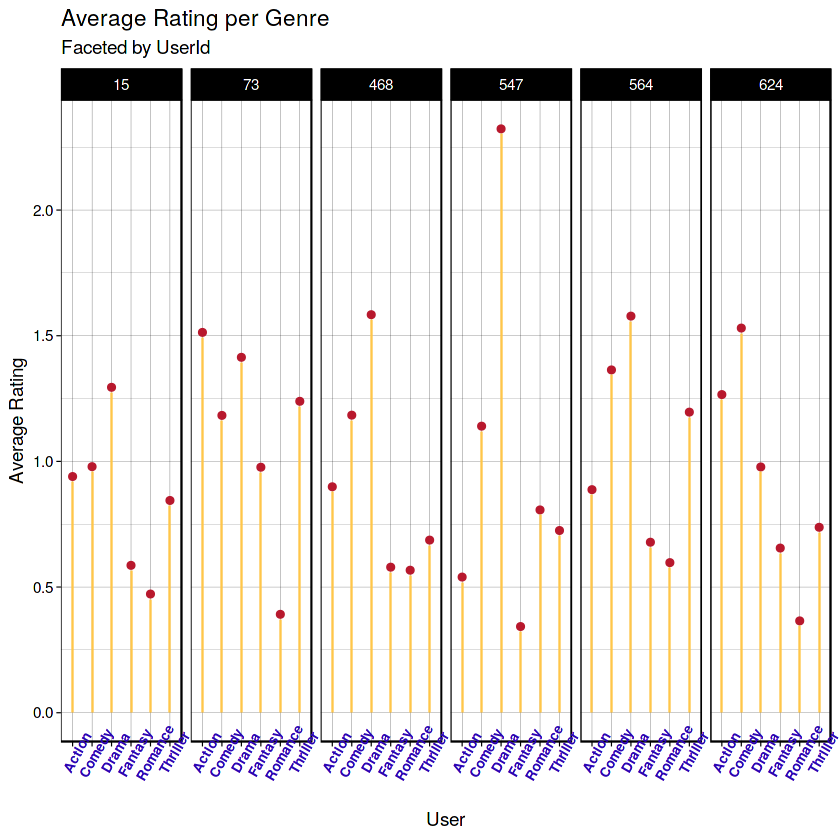

In [22]:
 movielens_genres[,c(1,5:10)] %>% group_by(userId) %>% summarize_all(mean)  %>% #compute the mean of each user in each genre
    gather(key = "Genre", value = "Average_Rating" , -userId) %>% #gather it for easier plotting
    ggplot( aes(x =  Genre, y = Average_Rating)) + 
    geom_point(col = "#b8182d") +
    facet_grid(~userId) +
    geom_segment(aes(x = Genre, y = 0, xend = Genre, yend = Average_Rating-.02), color = "#ffc64a") +
    labs(title = "Average Rating per Genre", subtitle = "Faceted by UserId", y = "Average Rating", x = "User")+
    theme_linedraw()+
    theme(axis.text.x = element_text(face = "bold", color = "#2b05b3", size = 8, angle = 60))
    

Pretty enlightening! No user has a balance in their preferences. Some love comedy, others like action, etc. That's a strong hindsight for the presence of hidden "concepts" in our data.

**Modeling**

**Train/Test Split**

In [23]:
#create train, test sets
set.seed(755)
test_index <- caret::createDataPartition(y = movielens$rating, times = 1, p = 0.2, list = FALSE)
train_set <- movielens[-test_index,]
test_set <- movielens[test_index,]

#make sure test set observations are also in train set
test_set <- test_set %>% 
  semi_join(train_set, by = "movieId") %>%
  semi_join(train_set, by = "userId")

**User and Movie Bias**

As mentioned above, we need to compute each movie's and user's bias. In order to control for the number of ratings, we need to penalize by term commonly referred to as lambda. To find the optimal lambda, we create a function that let's us that takes as input our dataframe and a vector of possible lambdas, computes the RMSE each lambda returned and outputs the lambda that yields the lowest rmse.

In [24]:
l_optimizer <- function(df, lambdas){

    rmses <- sapply(lambdas, function(l){

        #Calculate movie bias
        b_i <- train_set %>% 
          group_by(movieId) %>%
          summarize(b_i = sum(rating - mu)/(n()+l))

        #Calculate user bias
        b_u <- train_set %>% 
          left_join(b_i, by="movieId") %>%
          group_by(userId) %>%
          summarize(b_u = sum(rating - b_i - mu)/(n()+l))

        #Predict ratings  
        predicted_ratings <- test_set %>% 
            left_join(b_i, by='movieId') %>%
            left_join(b_u, by = "userId") %>%
            mutate(pred = mu + b_i + b_u) %>%
            pull(pred)

        #Calculate the error for the specific lambda
        return(RMSE(predicted_ratings, test_set$rating))
    })
 
 return(lambdas[which.min(rmses)])
}

In [25]:
#A vector of possible lambdas
lambdas <- seq(0, 7, 0.5)

#Assign the optimal lambda to a variable
lambda <- l_optimizer(train_set, lambdas)

In [26]:
#Take a look at it
print(paste("Optimal Lambda :",lambda))

[1] "Optimal Lambda : 3.5"


Now that we know the optimal lambda, we will go on to create the biases that will lead us to the residuals we seek to decompose.

In [27]:
#Calculate movie bias
b_i <- train_set %>% 
  group_by(movieId) %>%
  summarize(b_i = sum(rating - mu)/(n()+lambda))

#Calculate user bias
b_u <- train_set %>% 
  left_join(b_i, by="movieId") %>%
  group_by(userId) %>%
  summarize(b_u = sum(rating - b_i - mu)/(n()+lambda))

**Residuals**

Now that we obtained the regularized user and movie biases, we need to calculate what is left unexplained, ie the residual values. In other words, we need to compute all differences between actual ratings and our predictions so that we can further analyze these differences.

In [28]:
#Function to calculate the residuals

resids <- function( train_set = train_set, mu = mu ){
  
  #This function takes training set, calculates the residuals left after subtracting mu, user and movie bias
  #from actual rating and transforms it into a sparse matrix with movieIds as columns and users as row
    
  df <- train_set %>% 
           left_join(b_i, by = "movieId") %>%
           left_join(b_u, by = "userId") %>%
           mutate(res = rating - (mu + b_i + b_u) ) %>%
           select(userId, movieId, res) %>%
           spread( movieId, res ) %>% as.data.frame()
  
  #Name the rows
  rownames(df)<- df[,1]
  df <- df[,-1]
}

In [29]:
#convert our train set to residuals
tr <- resids(train_set = train_set,mu=mu)

In [30]:
#A quick look at the residual values
tr[1:10,1:10]

,1,2,3,4,5,6,7,8,9,10
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2,NA,NA,NA,NA,NA,NA,NA,NA,NA,0.6432275
3,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
4,NA,NA,NA,NA,NA,NA,NA,NA,NA,-0.1248799
5,NA,NA,0.2720315,NA,NA,NA,NA,NA,NA,NA
6,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
7,-0.6260769,NA,NA,NA,NA,NA,NA,NA,NA,-0.2067256
8,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
9,0.1805355,NA,NA,NA,NA,NA,NA,NA,NA,NA


#decompose residuals to obtain a recomposed matrix containing the latent factors' effect 
a <- funkSVD(tr, k = 4, min_epochs = 30, max_epochs = 100, min_improvement = .00005, verbose = T )

#recompose them (returns a full matrix in place of the sparse tr)
r <- tcrossprod(a$U, a$V)

colnames(r) <- colnames(tr)

#add on test set the appropriate p * q (recomposed) term

for (i in 1:nrow(test_set)){
  
  test_set$re[i] <-  r[ test_set$userId[i] , which(test_set$movieId[i] == colnames(r)) ]  
  

}

tes <- test_set %>% 
         left_join(b_i, by = "movieId") %>%
         left_join(b_u, by = "userId") %>%
         mutate(pred = mu + b_i + b_u + re)


ModelMetrics::rmse(tes$rating, tes$pred)

**SVD**

Now that we have the matrix of residuals, we de compose it in the best possible way. For that reason we will use the funkSVD function from the recommenderlab package. As its name suggests, it is not the tradiotional SVD. It uses a slightly different method, decomposing the initial matrix into two (and not three) matrices containing the latent factors for users and movies that minimize a specific objective function. For more details, refer [here](https://en.wikipedia.org/wiki/Matrix_factorization_(recommender_systems).

Because it contains many parameters, we will build a function that optimizes some of them.
These variables include:
   
* ks : number of features, or ranks of the approximation. In other words, how many "concepts" do we seek to unravel. A variable with high computational cost.
* gammas : regularization term
* lambdas : the rate by which we update our weights after each iteration. A low lambda can make our algorithm train for days, while a high one can lead us to miss the optimal weights. 
* min_improvement : the minimum amount of improvement derived from our objective that can be considered as improvement
* min_epochs : minimum number of iterations per feature

In [31]:
optimizer <- function(tr = tr,ks,gammas,lambdas,min_epochs, min_improvements){
  
    #Inputs: parameters of funkSVD function
    
  d <- data.frame(k = NULL, gamma = NULL, lambda = NULL, min_epochs = NULL, min_improvement = NULL, rmse = NULL)
          
        for (k in ks){
            for (g in gammas){
              for (l in lambdas){
                for (e in min_epochs){
                    for (imp in min_improvements) {

                        #decompose residuals with funk SVD 
                        a <- funkSVD(tr,
                                     k = k, 
                                     gamma = g, 
                                     lambda = l, 
                                     min_epochs = e, 
                                     max_epochs = 200, 
                                     min_improvement = imp, 
                                     verbose = FALSE )

                        #recompose them (returns a full matrix in place of the sparse tr)
                        r <- tcrossprod(a$U, a$V)

                        colnames(r) <- colnames(tr)

                        #add on test set the appropriate p * q (recomposed) term
                        test_set$re <- seq(0,nrow(test_set)-1)
                        for (i in 1:nrow(test_set)){

                              test_set$re[i] <-  r[ test_set$userId[i] , which(test_set$movieId[i] == colnames(r)) ]  
                        }
                        #calculate our prediction
                        tes <- test_set %>% 
                          left_join(b_i, by = "movieId") %>%
                          left_join(b_u, by = "userId") %>%
                          mutate(pred = mu + b_i + b_u + re)

                        #store results in a data frame
                        d <- d %>% rbind(data.frame(k = k, gamma = g, lambda = l,
                                                    min_epochs = e, min_improvement = imp,
                                                   rmse = ModelMetrics::rmse(tes$rating, tes$pred) ) )

              }}}}}
 
  return(d) 
}

Now that we defined our function, we also define the parameters we want to experiment with. Then, we run our optimizer, store the dataframe it yields in a variable and look at the optimal parameters that gave the minimums RMSE.

#Define the parameters
ks <- c(3,4)
gammas <- seq(.001,.009,.004)
lambdas <- seq(.004,.006,.008)
min_epochs <- c(10,25) 
min_improvements <- c(.0001)

In [32]:
#Define the parameters
ks <- c(3,5,7)
gammas <- c(.006)
lambdas <- c(.001)
min_epochs <- c(25) 
min_improvements <- c(.0001)

In [33]:
results <- optimizer(tr = tr,ks,gammas,lambdas,min_epochs, min_improvements)

In [34]:
results[which(results$rmse == min(results$rmse)),]

,k,gamma,lambda,min_epochs,min_improvement,rmse
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,3,0.006,0.001,25,1e-04,0.8815548


In [35]:
results %>% arrange((rmse) )

k,gamma,lambda,min_epochs,min_improvement,rmse
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3,0.006,0.001,25,1e-04,0.8815548
5,0.006,0.001,25,1e-04,0.8817677
7,0.006,0.001,25,1e-04,0.8820271


In [36]:
results %>% arrange((rmse) )

k,gamma,lambda,min_epochs,min_improvement,rmse
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3,0.006,0.001,25,1e-04,0.8815548
5,0.006,0.001,25,1e-04,0.8817677
7,0.006,0.001,25,1e-04,0.8820271
